# Analysis:

Several data frames will be derived from the Propublica data set that was updated to include the winners from Wikipedia. The data frame 'num_cans' will group the Propublica data frame by state giving the number of total candidates per state. Two other data frames will be derived, 'wins' and 'lost'. They will be combined with 'num_cans' to give the number of winning and losing candidates with PAC donations greater than 45% of their total donations as well as the percentage of total candidates who had PAC donation percentages greater than 45%, i. e., the percent that had greater than 45%. 

The following creates the data frames 'num_cans', 'wins' and 'lost' from the Propublica data set. 

In [179]:
import pandas as pd
pd.set_option('display.max_rows', None); pd.set_option('display.width', 1000)
pp = pd.read_csv('/.../propub_winners_csv_edit.csv') # Propulica edited CSV file

In [180]:
p2 = pp.copy(deep=True)
p2 = p2[(p2['total'] > 0) & ((p2['party'] == 'REP') | (p2['party'] == 'DEM'))]
p2['%_pac'] = round(100*(p2.pac / p2.total), 2)
p2['%>45'] = p2['%_pac'] > 45

num_cans = p2.copy(deep=True).groupby(['st'], as_index = False).agg({'name': 'count'})
num_cans.rename(columns = {'name':'#cans'}, inplace = True)

p4 =p2.copy(deep=True) #number of winners
wins = p4[(p4['%>45']) & (p4['win'] == 1)].groupby(['st'], as_index = False).agg({'name': 'count'})

p5 =p2.copy(deep=True) #number of losers
lost = p5[(p5['%>45']) & (p5['win'] == 0)].groupby(['st'], as_index = False).agg({'name': 'count'})

Remove all candidates who are not either Republicans or Democrats. Remove all candidates with no donations.

Calculate the amount of PAC donations as a percentage of the total donations.

Determine if the percentage of PAC donations is greater than 45%.

Create new data frame, 'num_cans', grouping by state, counting names to determine how many candidates ran in each state. 

Create new data frame, 'wins', that determines how many winning candidates per state had donations greater than 45% of total donations.

Create new data frame, 'lost', that determines how many losing candidates per state had donations greater than 45% of total donations.

Continuing below, 'wins' and 'lost' will be used to create new columns in 'num_cans.' 

In [181]:
num_cans['>45% wins'] = num_cans.apply(lambda i: wins[wins['st'] == i.st].name.values[0] 
                                       if not (wins[wins['st'] == i.st]).empty else 0, axis= 1)

num_cans['>45% lost'] = num_cans.apply(lambda i: lost[lost['st'] == i.st].name.values[0] 
                                       if not (lost[lost['st'] == i.st]).empty else 0, axis= 1)

num_cans['>45% as % of total'] = round((100*(num_cans['>45% wins'] + num_cans['>45% lost'])/num_cans['#cans']), 2)

num_cans = num_cans.sort_values((['>45% wins']), ascending=False)

As both 'wins' and 'lost' grouped the modified Propublica data set by state and aggregated by counting either the wins or the losses; searching into them by state will return either the number of wins or losses by candidates with PAC donations greater than 45%. If a state had no candidates with high PAC percentages, a zero was entered. 

In [182]:
print(num_cans) # final data set


    st  #cans  >45% wins  >45% lost  >45% as % of total
4   CA    212         24          5               13.68
42  TX    226         18          7               11.06
34  OH     48         11          3               29.17
8   FL    152         11          2                8.55
37  PA     53         10          0               18.87
13  IL     66          9          2               16.67
33  NY    131          8          3                8.40
9   GA     86          7          1                9.30
26  NC     79          6          1                8.86
30  NJ     57          6          0               10.53
14  IN     45          6          1               15.56
23  MO     25          5          1               24.00
16  KY     17          5          0               29.41
46  WA     41          5          1               14.63
21  MI     61          5          2               11.48
5   CO     20          4          1               25.00
1   AL     27          4          1             

In [189]:
print(num_cans['>45% as % of total'].describe()) #summary statistics


count     50.000000
mean      17.792200
std       16.551416
min        0.000000
25%        8.587500
50%       13.735000
75%       23.555000
max      100.000000
Name: >45% as % of total, dtype: float64


Create stacked bar chart of candidates with PAC donations greater than 45% who both won and lost. This will allow us to see how effective large PAC donations were.

<function matplotlib.pyplot.show(*args, **kw)>

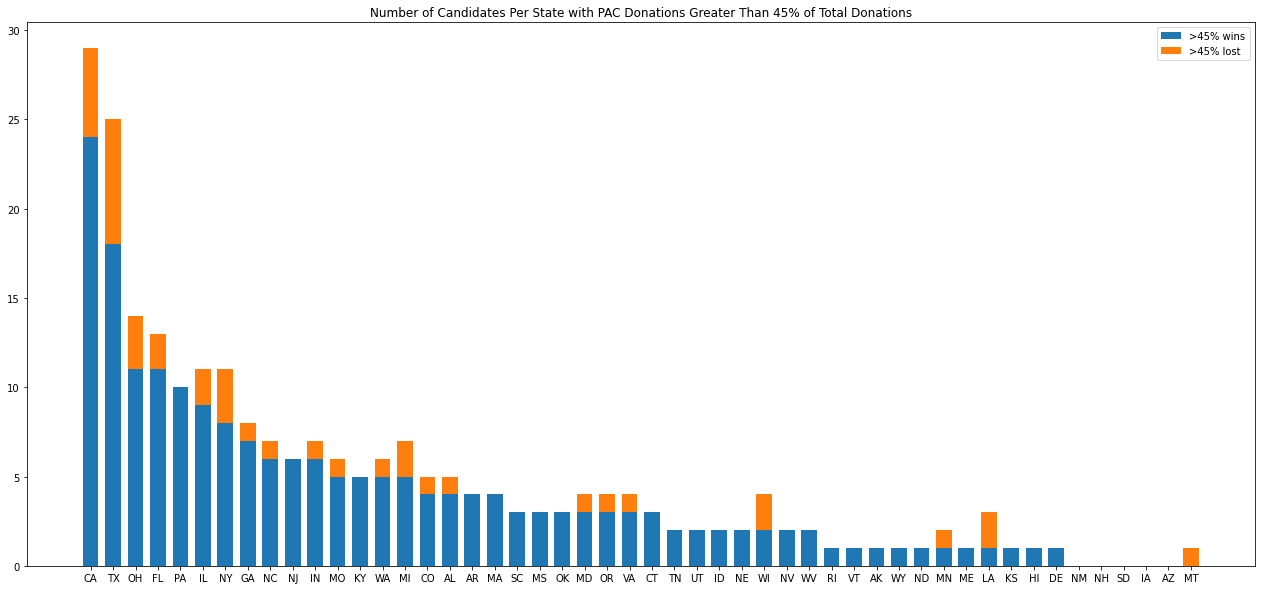

In [183]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize = (22,10))

plt.bar(num_cans.st, num_cans['>45% wins'], 0.7, label = '>45% wins')
plt.bar(num_cans.st, num_cans['>45% lost'], 0.7, bottom = num_cans['>45% wins'], label = '>45% lost')
plt.legend()
plt.title('Number of Candidates Per State with PAC Donations Greater Than 45% of Total Donations')
plt.savefig('final_stack_bar.svg')

plt.show

Create scatter plot of total number of candidates versus those with high PAC percentages as a percentage of the total number of candidates. Smaller states seem to have a higher number of candidates with high PAC percentages. 

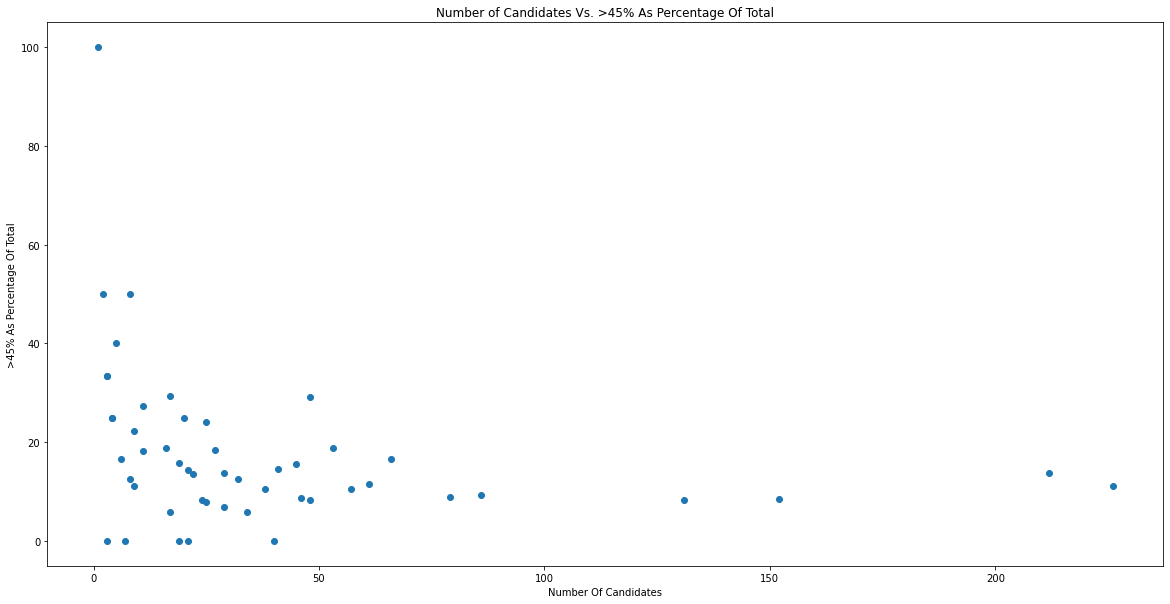

In [184]:
plt.figure(figsize = (20,10))

plt.scatter(x = num_cans['#cans'], y = num_cans['>45% as % of total'])
plt.title('Number of Candidates Vs. >45% As Percentage Of Total')

plt.xlabel('Number Of Candidates')
plt.ylabel('>45% As Percentage Of Total')
plt.savefig('final_scatter.svg')
plt.show()



Function to analyze data by state. Returns list of data frames. Uses Propublica data set, similar to the above.

DF1: Remove candidates who are not Republican or Democrat or who had $0 donations, calculate PAC donations as percentage of total, determine if candidate's donations greater than 45 percent? 

Df2: DF1 grouped by party. Sum of total donations and PAC donations by party. 

DF3: Filter DF2 to show candidates with PAC contributions greater than 45 percent. 

DF4: Number of winners with PAC donations greater than 45 percent by party. 

In [170]:
def analyze(df, state): #analysis of individual states
    df1 = df[df['st'] == state]
    df1 = df1[(df1['total'] > 0) & ((df1['party'] == 'REP') | (df1['party'] == 'DEM'))]
    df1['%_pac'] = round(100*(df1.pac / df1.total), 2)
    df1['%>45'] = df1['%_pac'] > 45
    
    #sum total & pac contribs. by party
    df2 = df1.groupby(['party'], as_index = False).agg({'total':'sum','pac':'sum'}) 
    df2['%_pac'] = round(100*(df2.pac / df2.total), 2)
    
    #candidates with contributions greater than 45%
    df3 = df1[df1['%>45']]
    
    #count of candidates with contributions greater than 45% by party
    df4 = df3.groupby(['party']).agg({'win':'count'})
    
    return df1, df2, df3, df4

Example:

In [191]:
print(analyze(pp, 'GA')[2]) # candidates with contributions greater than 45% in Georgia

     st  dist                         name         id party    total      pac  win  %_pac  %>45
869  GA     1           carter, earl leroy  H4GA01039   REP  2341693  1205934    1  51.50  True
879  GA     2              bishop, sanford  H2GA02031   DEM  1486115  1105144    1  74.36  True
880  GA     3   ferguson, anderson drew iv  H6GA03113   REP  2240752  1452321    1  64.81  True
884  GA     4      johnson, henry c. 'hank  H6GA04129   DEM   634286   509375    1  80.31  True
933  GA     8          scott, james austin  H0GA08099   REP   828258   542300    1  65.47  True
961  GA    11            loudermilk, barry  H4GA11061   REP   875086   638050    1  72.91  True
972  GA    13          scott, david albert  H2GA13012   DEM  1210110  1025900    1  84.78  True
990  GA    14  graves, john thomas mr. jr.  H0GA09030   REP   689049   548250    0  79.57  True
